# Get answers for all no choices tests

In [1]:
import json
import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
from word2number import w2n
import csv
import re
import math
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Get raw question and answer data
f = open('../../reVLAT_QAs.json')
qaDict = json.load(f)

dirList = ['reVLAT_Viz+Choices',
           'reVLAT_NoViz+Choices',
           'reVLAT_Viz+NoChoices',
           'reVLAT_NoViz+NoChoices']

In [3]:
taskTypes = {
    'comparisons': 'make comparisons',
    'correlations': 'find correlations/trends',
    'extremum': 'find extremum',
    'value': 'retrieve value',
    'range': 'determine range'
}

In [9]:
# Get all the results
# df = pd.read_csv('../allResults.csv')
resultsNoChoices = pd.read_csv('noChoicesResults.csv')
# resultsNoChoices = df[df['expType'].astype(str).str.contains('NoChoices')]

# csvFilePath = '../noChoicesResults.csv'
# csvFilePath = '/Users/jhong76/Downloads/noChoicesResults-csv.csv'
# resultsNoChoices.to_csv(csvFilePath, index=False)

resultsNoChoices_types = {} 
for type in taskTypes.keys():
    resultsNoChoices_types[type] = resultsNoChoices[resultsNoChoices['qType_simple'] == taskTypes[type]]
    

In [5]:
def wordToNum(text):
    try: 
        result = w2n.word_to_num(text)
        return result
    except:
        return text

In [26]:
valueCounts = {}

for i in resultsNoChoices.response:
    # Delete the dot in the end
    i = str(i)
    i = i.rstrip('.')
    # Delete Approximately
    i = i.replace('Approximately', '')
    # Delete space in the beginning
    i = i.lstrip()
    if i not in valueCounts:
        valueCounts[i] = 1
    else:
        valueCounts[i] += 1

print(len(valueCounts))

with open('noChoices/noChoices_Responses_counts.json', 'w') as f:
    json.dump(valueCounts, f, indent=4)

984


In [48]:
valueCounts = {}

for type in taskTypes.keys():
    valueCounts[type] = {}
    for i in resultsNoChoices_types[type]['response']:
        # Delete the dot in the end
        i = str(i)
        i = i.rstrip('.')
        # Delete Approximately
        i = i.replace('Approximately', '')
        # Delete space in the beginning
        i = i.lstrip()
        # change word to digit
        i = wordToNum(i)
        if i not in valueCounts[type]:
            valueCounts[type][i] = 1
        else:
            valueCounts[type][i] += 1

    with open('noChoices_'+type+'_Responses_counts.json', 'w') as f:
        json.dump(valueCounts[type], f, indent=4)

In [5]:
def has_numbers(inputString):
    if isinstance(inputString, float):
        return True
    return any(char.isdigit() for char in inputString)

In [4]:
def extract_numbers(s):
    if ('330km' in str(s)): return [330000]
    s = str(s).replace(',', '')
    if (str(s).isdigit()): return [float(s)]
    # Use regex to extract numbers from the string
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    # Convert the extracted numbers to float
    numbers = [float(num) for num in numbers]
    if ("to" in str(s)): return [numbers[0]/numbers[1]]
    return numbers

In [6]:
wrongFormat = ['Vague',
           'Unknown',
           'Random',
           'Prompt Engineering']

In [11]:
totalTextNum = 0
correctTextNum = 0
formatTextNum = 0

totalRightTypeNum = 0
totalNumericalNum = 0
correctNumericalNum = 0
resultsNoChoices.absoluteError = np.nan
resultsNoChoices.relativeError = np.nan
for index, row in resultsNoChoices.iterrows():
    # deal with textual response
    if (not has_numbers(row.answer)):
        if (not has_numbers(row.response)):
            totalTextNum += 1
            if any(row.response in f for f in wrongFormat): formatTextNum += 1
            if (row.answer in row.response):
                resultsNoChoices.loc[index, 'correct'] = 1
                correctTextNum += 1
            else:
                resultsNoChoices.loc[index, 'correct'] = 0
    # deal with numerical response
    else:
        if ("When was the average price" in row.question or
            "when was the number of girls named" in row.question):
            totalTextNum += 1
            if any(row.response in f for f in wrongFormat): formatTextNum += 1
            if (row.response != row.answer):
                resultsNoChoices.loc[index, 'correct'] = 0
            else: 
                resultsNoChoices.loc[index, 'correct'] = 1
                correctTextNum += 1
            continue
        if (not has_numbers(row.response)):
            resultsNoChoices.loc[index, 'correct'] = 0
            continue
        if (row.qType == "Determine Range"): continue
        if ("was the unemployment rate for Indiana" in row.question):
            if (row.response != row.response):
                resultsNoChoices.loc[index, 'correct'] = 0
                continue
            if (not has_numbers(row.response)):
                resultsNoChoices.loc[index, 'correct'] = 0
                continue
            elif (row.response == "4.6%" or row.response == "4.8%"): continue
            else:
                response = extract_numbers(row.response)[0]
                if (response >= 1.1 and response <= 2.3):
                    resultsNoChoices.loc[index, 'correct'] = 1
                else: resultsNoChoices.loc[index, 'correct'] = 0
                continue
        if("rated the taxi the most" in row.question):
            if (has_numbers(row.response)):
                response = extract_numbers(row.response)[0]
                if (response >= 4 and response <= 4.2):
                    resultsNoChoices.loc[index, 'correct'] = 1
                else: resultsNoChoices.loc[index, 'correct'] = 0
            else: resultsNoChoices.loc[index, 'correct'] = 0
            continue
        if (row.response != row.response):
            resultsNoChoices.loc[index, 'correct'] = 0
            continue
        totalRightTypeNum += 1
        response = extract_numbers(row.response)[0]
        trueAnswer = extract_numbers(row.answer)[0]
        resultsNoChoices.loc[index, 'absoluteError'] = abs(response - trueAnswer)
        resultsNoChoices.loc[index, 'relativeError'] = abs(response - trueAnswer)/trueAnswer
print("Text Accuracy Rate:", correctTextNum, totalTextNum, formatTextNum)
print("Num Accuracy Rate:", totalRightTypeNum)
# Save the modified DataFrame back to the CSV file
resultsNoChoices.to_csv('noChoicesResults_text_singleWord.csv', index=False)

# with open('noChoices/noChoices_Responses_counts.json', 'w') as f:
#     json.dump(valueCounts, f, indent=4)

Text Accuracy Rate: 4587 14243 1290
Num Accuracy Rate: 4614


In [9]:
def calculateConfidenceInterval(df, property):
    stats = df.groupby(['LLM', 'expType'])[property].agg(['mean', 'count', 'std'])
    
    ci95_hi = []
    ci95_lo = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        print(i, m, c, s)
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))
    
    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo
    
    return stats


In [16]:
# Creating Confidence Interval
def createCIFigure(data, property):
    stats = calculateConfidenceInterval(data, property)

    xerr = [[mean - low for mean, low in zip(stats['mean'], stats['ci95_lo'])], [hi - mean for mean, hi in zip(stats['mean'], stats['ci95_hi'])]]

    font = {'fontname':'Arial'}
    labels = ['ChatGPT+NoVis', 'ChatGPT+Vis', 'Gemini+NoVis', 'Gemini+Vis']
    y = [1,1.5,2,2.5]
    width = 0.3

    plt.figure(figsize=(10, 5))
    fig, ax = plt.subplots()

    ax.barh(y, stats['mean'], width, label='Mean', xerr=xerr, color="#5f89c2", capsize = 3, ecolor="#001D4A")

    # Add labels, title, and legend
    ax.set_ylabel(property, **font, fontsize=12)
    ax.set_title(property+' by Condintions', **font, fontsize=12)
    ax.set_yticks(y)
    ax.set_yticklabels(labels, **font, fontsize=12)
    ax.legend()

    # plt.xlim(0, 2.5)
    plt.grid(axis='x', color='gray', linestyle='-', linewidth=0.5)
    # plt.savefig("../../Figures/CI_NoChoices_SingleValue_RelativeError.pdf")
    # Show plot
    plt.show()

In [ ]:
createCIFigure(resultsNoChoices, 'relativeError')

In [11]:
textualQuestions = {
    'Line Chart': [2,4],
    'Bar Chart': [2],
    'Stacked Bar Chart': [3,4,5],
    '100% Stacked Bar Chart': [2,3],
    'Pie Chart': [2,3],
    'Histogram': [3],
    'Scatterplot': [5,6,7],
    'Bubble Chart': [2,4,5,6,7],
    'Area Chart': [2,4],
    'Stacked Area Chart': [3,4,5,6],
    'Choropleth Map': [2,3],
    'Treemap': [1,2,3]
}

resultsNoChoices = pd.read_csv('noChoicesResults_text_singleWord.csv')

textual = []
for index, row in resultsNoChoices.iterrows():
    if (row.qNum in textualQuestions[row.chartType]):
        textual.append(row)

resultsTextual = pd.DataFrame(textual)

        index               chartType  qNum  \
0      1539.0  100% Stacked Bar Chart     2   
2       461.0                 Treemap     3   
3       605.0       Stacked Bar Chart     3   
4       700.0              Area Chart     2   
5      1975.0              Line Chart     4   
...       ...                     ...   ...   
25432  4177.0            Bubble Chart     5   
25434   649.0            Bubble Chart     6   
25435  5381.0      Stacked Area Chart     6   
25438  3977.0       Stacked Bar Chart     4   
25439  5630.0      Stacked Area Chart     4   

                                                question              answer  \
0      What is the education level of people in which...  Postgraduate Study   
2             Amazon is nested in the Computer category.               False   
3         In which city is the cost of soda the highest?             Chicago   
4      When was the average price of a pound of coffe...          March 2013   
5      Over the course of the secon

('ChatGPT', 'reVLAT_NoViz+NoChoices') 0.2833333333333333 3480.0 0.4506816189118304
('ChatGPT', 'reVLAT_Viz+NoChoices') 0.38272295219457647 3577.0 0.4861194898397104
('Gemini', 'reVLAT_NoViz+NoChoices') 0.29726715002788623 3586.0 0.45711887069370544
('Gemini', 'reVLAT_Viz+NoChoices') 0.3238888888888889 3600.0 0.4680232073062823


<Figure size 1000x500 with 0 Axes>

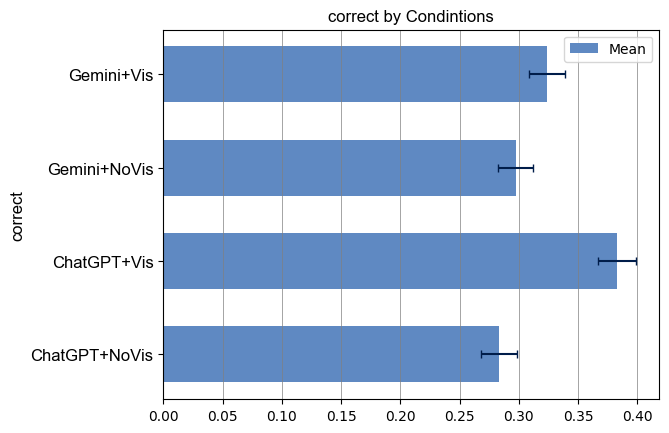

In [17]:
createCIFigure(resultsTextual, 'correct')